In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("skygeni_sales_data.csv")

**Data Exploration**

In [ ]:
# Data Summary
print(f"Number of Records: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")
print("\nColumn Info:")
print(df.info())

Number of Records: 5000
Number of Columns: 12

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   deal_id           5000 non-null   object
 1   created_date      5000 non-null   object
 2   closed_date       5000 non-null   object
 3   sales_rep_id      5000 non-null   object
 4   industry          5000 non-null   object
 5   region            5000 non-null   object
 6   product_type      5000 non-null   object
 7   lead_source       5000 non-null   object
 8   deal_stage        5000 non-null   object
 9   deal_amount       5000 non-null   int64 
 10  sales_cycle_days  5000 non-null   int64 
 11  outcome           5000 non-null   object
dtypes: int64(2), object(10)
memory usage: 468.9+ KB
None


In [ ]:
# Change the data type of date to datetime
df['closed_date'] = pd.to_datetime(df['closed_date'])
df['created_date'] = pd.to_datetime(df['created_date'])

# Create a new 'quarter' column (e.g., '2023Q4')
df['quarter'] = df['created_date'].dt.to_period('Q').astype(str)
print(df['quarter'].head())

0    2023Q4
1    2023Q1
2    2023Q4
3    2023Q3
4    2024Q1
Name: quarter, dtype: object


In [ ]:
# Data summary and statistics
print(df['sales_cycle_days'].describe())
print("\n")
print(df['deal_amount'].describe())

count    5000.000000
mean       63.751800
std        32.731405
min         7.000000
25%        35.750000
50%        64.000000
75%        92.000000
max       120.000000
Name: sales_cycle_days, dtype: float64


count      5000.000000
mean      26286.492800
std       27689.230136
min        2002.000000
25%        6611.000000
50%       14171.500000
75%       39062.250000
max      100000.000000
Name: deal_amount, dtype: float64


**Creating Custom Metrics**

Custom Metric 1: Pipeline Velocity

This single truth metric balances volume against quality. It reveals if a healthy pipeline volume is actually generating revenue or just bloating the system with slow, low-probability deals.

In [ ]:
# PV = (Total Opps * Avg Deal Value (Won) * Win Rate) / Avg Sales Length
def calculate_quarterly_pv(data):
    total_opps = len(data)
    won_deals = data[data['outcome'] == 'Won']
    avg_deal_value = won_deals['deal_amount'].mean() if not won_deals.empty else 0
    win_rate = (data['outcome'] == 'Won').mean()
    avg_cycle = data['sales_cycle_days'].mean()

    if avg_cycle == 0: return 0
    return (total_opps * avg_deal_value * win_rate) / avg_cycle

# Apply per quarter and map back to create the column
pv_per_quarter = df.groupby('quarter').apply(calculate_quarterly_pv).to_dict()
df['pipeline_velocity'] = df['quarter'].map(pv_per_quarter)

print(df['pipeline_velocity'].head())

0    202443.107023
1    167482.232302
2    202443.107023
3    194573.164422
4    181919.002510
Name: pipeline_velocity, dtype: float64


/tmp/ipython-input-3404332291.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pv_per_quarter = df.groupby('quarter').apply(calculate_quarterly_pv).to_dict()


Custom Metric 2: Win Rate by Region

This metric determines Segment Health. They reveal if the win rate drop is a systemic company-wide issue or isolated to a specific market.

In [ ]:
# Calculating Win Rate per Region per Quarter and merging back as a column
win_rate_per_segment = df.groupby(['quarter', 'region'])['outcome'].apply(lambda x: (x=='Won').mean()).reset_index()
win_rate_per_segment.rename(columns={'outcome': 'region_win_rate'}, inplace=True)
df = pd.merge(df, win_rate_per_segment, on=['quarter', 'region'], how='left')

In [ ]:
# Show the new columns
print(df[['quarter', 'pipeline_velocity', 'region_win_rate']].head())

  quarter  pipeline_velocity  region_win_rate
0  2023Q4      202443.107023         0.496124
1  2023Q1      167482.232302         0.447273
2  2023Q4      202443.107023         0.457265
3  2023Q3      194573.164422         0.465306
4  2024Q1      181919.002510         0.430962


In [ ]:
print(df.columns)

Index(['deal_id', 'created_date', 'closed_date', 'sales_rep_id', 'industry',
       'region', 'product_type', 'lead_source', 'deal_stage', 'deal_amount',
       'sales_cycle_days', 'outcome', 'quarter', 'pipeline_velocity',
       'region_win_rate'],
      dtype='object')


**Data Visualizations for Key Business Insights**

Visualization 1: Win Rate Trend

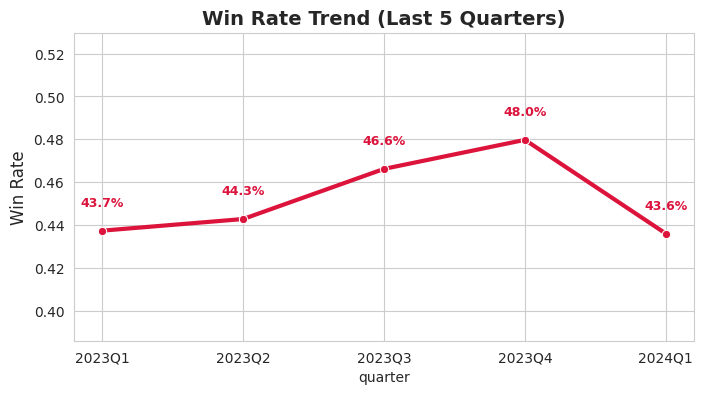

In [ ]:
# Set plotting style
sns.set_style("whitegrid")

# Calculate quarterly win rate
quarterly_trend = df.groupby('quarter')['outcome'].apply(lambda x: (x == 'Won').mean()).reset_index()

plt.figure(figsize=(8, 4))
sns.lineplot(data=quarterly_trend, x='quarter', y='outcome', marker='o', color='crimson', linewidth=3)

# For adding labels
for x, y in zip(quarterly_trend['quarter'], quarterly_trend['outcome']):
    plt.text(x, y + 0.01, f'{y:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='crimson')

# Standard Styling
plt.title('Win Rate Trend (Last 5 Quarters)', fontsize=14, fontweight='bold')
plt.ylabel('Win Rate', fontsize=12)
plt.ylim(quarterly_trend['outcome'].min() - 0.05, quarterly_trend['outcome'].max() + 0.05)
plt.show()

Visualization 2: Win Rate Trend by Region.

([0, 1, 2, 3, 4],
 [Text(0, 0, '2023Q1'),
  Text(1, 0, '2023Q2'),
  Text(2, 0, '2023Q3'),
  Text(3, 0, '2023Q4'),
  Text(4, 0, '2024Q1')])

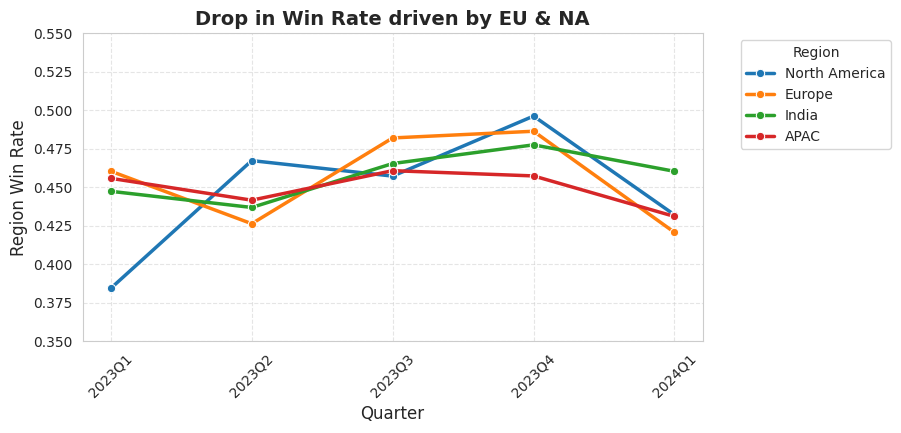

In [ ]:
# Region Win Rate Trend
plt.figure(figsize=(8, 4))
df_viz = df.sort_values('quarter')

sns.lineplot(
    data=df_viz, x='quarter', y='region_win_rate',
    hue='region', marker='o', linewidth=2.5, palette='tab10', errorbar=None
    )

plt.title('Drop in Win Rate driven by EU & NA', fontsize=14, fontweight='bold')
plt.ylabel('Region Win Rate', fontsize=12)
plt.xlabel('Quarter', fontsize=12)
plt.ylim(0.35, 0.55)
plt.legend(title='Region', fontsize='medium', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

Visualization 3: Comparision between Pipeline Volume and Pipeline Velocity to investigate the sudden drop in win rate.

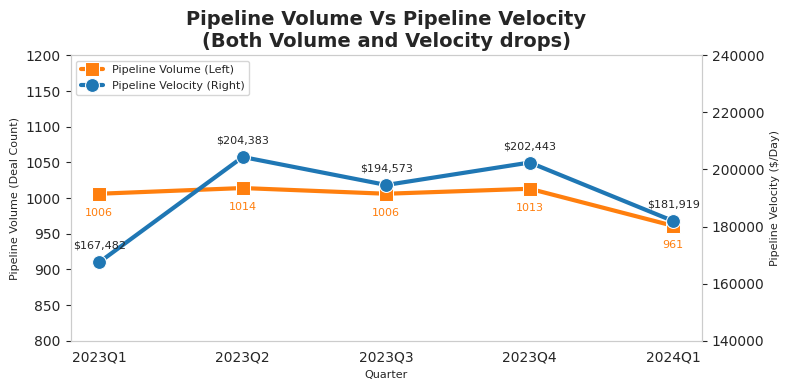

In [ ]:
# Calculate Pipeline Volume for each quarter (Count of total deals for each quarter)
vol_df = df.groupby('quarter')['deal_id'].count().reset_index(name='Pipeline_Volume')
vel_df = df[['quarter', 'pipeline_velocity']].drop_duplicates()

# Merge metrics into one dataframe for plotting
combo_df = pd.merge(vol_df, vel_df, on='quarter')

# 2. Visualization (Dual Axis Line Chart)
fig, ax1 = plt.subplots(figsize=(8, 4))

# Axis 1 (Left): Volume (Orange Line)
sns.lineplot(
    data=combo_df, x='quarter', y='Pipeline_Volume',
    color='tab:orange', marker='s', markersize=10, linewidth=3,
    ax=ax1, label='Pipeline Volume', legend=False
    )
ax1.set_ylabel('Pipeline Volume (Deal Count)', fontsize=8)
ax1.tick_params(axis='y')
ax1.set_xlabel('Quarter', fontsize=8)
ax1.set_ylim(800, 1200) # Adjust scale to focus on the trend
ax1.grid(False) # Turn off grid for cleaner look

# Add Volume Labels (below points)
for i, row in combo_df.iterrows():
    ax1.text(i, row['Pipeline_Volume'] - 20, f"{row['Pipeline_Volume']}",
             color='tab:orange', ha='center', va='top', fontsize=8)

# Axis 2 (Right): Velocity (Blue Line)
ax2 = ax1.twinx()
sns.lineplot(
    data=combo_df, x='quarter', y='pipeline_velocity',
    marker='o', markersize=10, linewidth=3,
    ax=ax2, label='Pipeline Velocity', legend=False
    )
ax2.set_ylabel('Pipeline Velocity ($/Day)', fontsize=8)
ax2.tick_params(axis='y')
ax2.set_ylim(140000, 240000) # Align scale to show movement
ax2.grid(False)

# Add Velocity Labels (above points)
for i, row in combo_df.iterrows():
    ax2.text(i, row['pipeline_velocity'] + 4000, f"${row['pipeline_velocity']:,.0f}",
             ha='center', va='bottom', fontsize=8)

# Legend Handling
# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, ['Pipeline Volume (Left)', 'Pipeline Velocity (Right)'], loc='upper left', fontsize=8)

# Final Touches
plt.title('Pipeline Volume Vs Pipeline Velocity\n(Both Volume and Velocity drops)', fontsize=14, fontweight='bold')
plt.tight_layout()

plt.show()

Visualization 4: Deal Loss Distribution by Stage

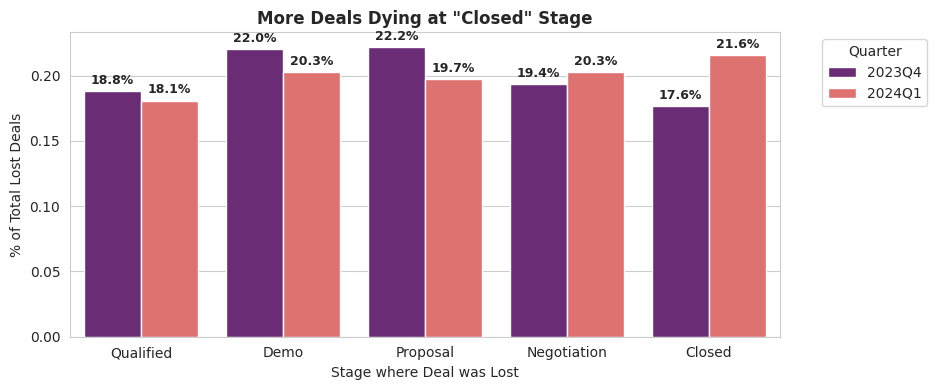

In [ ]:
# Observation: In 2024Q1, significantly more deals died at the final "Closed" stage compared to 2023Q4.
# Implication: Sales reps are failing to close deals at the final signature step.

plt.figure(figsize=(8, 4))

# 1. Prepare Data
q_good = '2023Q4'
q_bad = '2024Q1'
df_loss = df[(df['outcome'] == 'Lost') & (df['quarter'].isin([q_good, q_bad]))].copy()

# Calculate % of losses per stage
loss_counts = df_loss.groupby(['quarter', 'deal_stage']).size().reset_index(name='count')
total_losses = df_loss.groupby('quarter').size().reset_index(name='total')
loss_dist = pd.merge(loss_counts, total_losses, on='quarter')
loss_dist['pct_loss'] = loss_dist['count'] / loss_dist['total']

# 2. Define the Hierarchical Order
stage_order = ['Qualified', 'Demo', 'Proposal', 'Negotiation', 'Closed']

# 3. Plot with 'order' parameter
ax = sns.barplot(
    data=loss_dist,
    x='deal_stage',
    y='pct_loss',
    hue='quarter',
    palette='magma',
    order=stage_order
)

# For adding labels to each bar
for container in ax.containers:
    labels = [f'{val:.1%}' for val in container.datavalues]
    ax.bar_label(container, labels=labels, padding=3, fontsize=9, fontweight='bold')

plt.title('More Deals Dying at "Closed" Stage', fontsize=12, fontweight='bold')
plt.ylabel('% of Total Lost Deals')
plt.xlabel('Stage where Deal was Lost')

plt.tight_layout()
plt.legend(title='Quarter', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()